In [1]:
import jax
import jax.numpy as jnp
import genjax
from genjax import grasp
import matplotlib.pyplot as plt
from functools import reduce
from jax.scipy.special import logsumexp

In [2]:
console = genjax.pretty()

In [3]:
# from https://github.com/mattjj/svae/blob/master/experiments/gmm_svae_synth.py
def make_pinwheel_data(
    key, radial_std, tangential_std, num_classes, num_per_class, rate
):
    keys = jax.random.split(key, 2)
    rads = jnp.linspace(0, 2 * jnp.pi, num_classes, endpoint=False)

    features = jax.random.normal(keys[0], (num_classes * num_per_class, 2)) * jnp.array(
        [radial_std, tangential_std]
    )
    features = features.at[:, 0].add(1.0)
    labels = jnp.repeat(jnp.arange(num_classes), num_per_class)

    angles = rads[labels] + rate * jnp.exp(features[:, 0])
    rotations = jnp.stack(
        [jnp.cos(angles), -jnp.sin(angles), jnp.sin(angles), jnp.cos(angles)]
    )
    rotations = jnp.reshape(rotations.T, (-1, 2, 2))

    return 10 * jax.random.permutation(
        keys[1], jnp.einsum("ti,tij->tj", features, rotations)
    )

50


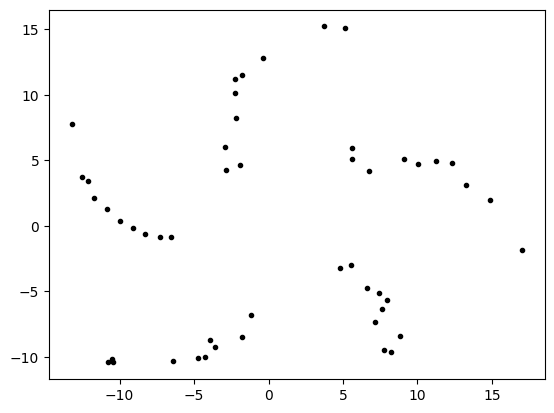

In [4]:
NUM_CLUSTERS = 5
POINTS_PER_CLUSTER = 10
N = NUM_CLUSTERS * POINTS_PER_CLUSTER
print(N)
pinwheel = make_pinwheel_data(
    jax.random.PRNGKey(0), 0.3, 0.05, NUM_CLUSTERS, POINTS_PER_CLUSTER, 0.25
)
plt.scatter(pinwheel[:, 0], pinwheel[:, 1], marker=".", c="black")

---

In [5]:
mlp = lambda x, ws: reduce(lambda z, w: jax.nn.leaky_relu(w @ z), ws, x)
matsqr = lambda x: x @ x
toprob = lambda logits: jnp.exp(logits - logsumexp(logits))

In [6]:
@genjax.gen
def model(params):
    for i in range(N):
        z = grasp.categorical_enum(toprob(params["logits"])) @ ("z", i)
        cluster_mean = jax.lax.dynamic_index_in_dim(params["means"], z, keepdims=False)
        cluster_scale = jax.lax.dynamic_index_in_dim(
            params["scales"], z, keepdims=False
        )
        x = grasp.mv_normal_reparam(cluster_mean, matsqr(cluster_scale)) @ ("x", i)
        point_mean = mlp(x, params["mean_ws"])
        point_scale = mlp(x, params["scale_ws"]).reshape(2, 2)
        grasp.mv_normal_reparam(point_mean, matsqr(point_scale)) @ ("y", i)

In [7]:
key = jax.random.PRNGKey(0)
model_params = {
    "logits": jnp.ones(NUM_CLUSTERS),
    "means": jnp.arange(2 * NUM_CLUSTERS, dtype=jnp.float32).reshape(NUM_CLUSTERS, 2),
    "scales": jnp.ones((NUM_CLUSTERS, 2, 2)),
    "mean_ws": (
        jax.random.uniform(key, (10, 2)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (2, 10)),
    ),
    "scale_ws": (
        jax.random.uniform(key, (10, 2)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (4, 10)),
    ),
}

In [8]:
key = jax.random.split(key)[0]
model.simulate(key, (model_params,)).strip();

In [9]:
@genjax.gen
def variational_family(data, params):
    for i in range(N):
        cluster_mean = mlp(data[("y", i)], params["mean_ws"])
        cluster_scale = mlp(data[("y", i)], params["scale_ws"]).reshape(2, 2)
        x = grasp.mv_normal_reparam(cluster_mean, matsqr(cluster_scale)) @ ("x", i)
        z = grasp.categorical_enum(toprob(mlp(x, params["cat_ws"]))) @ ("z", i)

In [10]:
vf_params = {
    "mean_ws": (
        jax.random.uniform(key, (10, 2)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (2, 10)),
    ),
    "scale_ws": (
        jax.random.uniform(key, (10, 2)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (4, 10)),
    ),
    "cat_ws": (
        jax.random.uniform(key, (10, 2)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (10, 10)),
        jax.random.uniform(key, (NUM_CLUSTERS, 10)),
    ),
}

In [11]:
pinwheel_data = genjax.choice_map({("y", i): pinwheel[i, :] for i in range(N)})
key = jax.random.split(key)[0]
variational_family.simulate(key, (pinwheel_data, vf_params));

In [12]:
loss = grasp.elbo(model, variational_family, pinwheel_data)

In [13]:
jax.jit(loss.value_and_grad_estimate)(key, ((model_params,), (pinwheel_data, vf_params)))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 jax.jit(loss.value_and_grad_estimate)(key, ((model_params,), (pinwheel_data, vf_params))     │
│   2                                                                                              │
│                                                                                                  │
│ /home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/jax/_src/traceback_util.py:177   │
│ in reraise_with_filtered_traceback                                                               │
│                                                                                                  │
│ /home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/jax/_src/pjit.py:256 in          │
│ cache_miss                                                                                       │
│                                                                                                  │
│ /home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/jax/_src/pjit.py:162 in          │
│ _python_pjit_helper                                                                              │
│                                                                                                  │
│ /home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/jax/_src/api.py:314 in           │
│ infer_params                                                                                     │
│                                                                                                  │
│ /home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/jax/_src/pjit.py:486 in          │
│ common_infer_params                                                                              │
│                                                                                                  │
│ /home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/jax/_src/pjit.py:963 in          │
│ _pjit_jaxpr                                                                                      │
│                                                                                                  │
│ /home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/jax/_src/linear_util.py:349 in   │
│ memoized_fun                                                                                     │
│                                                                                                  │
│ /home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/jax/_src/pjit.py:916 in          │
│ _create_pjit_jaxpr                                                                               │
│                                                                                                  │
│ /home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/jax/_src/profiler.py:340 in      │
│ wrapper                                                                                          │
│                                                                                                  │
│ /home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/jax/_src/interpreters/partial_ev │
│ al.py:2278 in trace_to_jaxpr_dynamic                                                             │
│                                                                                                  │
│ /home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-packages/jax/_src/interpreters/partial_ev │
│ al.py:2300 in trace_to_subjaxpr_dynamic                                                          │
│                                                                                                  │
│ /home/femtomc/miniconda3/envs/pyro/lib/python3.10/site-pack